In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# %%
def remove_trailing_period(value):
    if isinstance(value, str) and value.endswith('.'):
        return value[:-1]
    return value
X = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\rdkit_right_desc.csv', index_col=0)
y = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\target_right_desc.csv', index_col=0)['0']
y = pd.DataFrame(y)
cons = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['siRNA concentration'].apply(remove_trailing_period).astype(float)
X['Concentration_nM'] = cons[cons <= 100]
X['Experiment_used_to_check_activity'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Experiment used to check activity'].astype(float)
X['Target_gene'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Target gene'].astype(float)
#X['siRNA_concentration'] = pd.read_csv('E:\\My_projects\\ready_to_go_2.csv')['siRNA concentration'].astype(float)
X['Cell_or_Organism_used'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Cell or Organism used'].astype(float)
X['Transfection_method'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Transfection method'].astype(float)
X['Duration_after_transfection'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Duration after transfection'].astype(float)
X['target'] = y
X = X.drop_duplicates()
y = X['target']
X = X.drop(columns=['target'])

#X['Experiment_used_to_check_activity'] = X['Experiment_used_to_check_activity'].replace(3, 4).replace(17, 19).replace(2, 4)
#X['Transfection_method'] = X['Transfection_method'].replace(20, 19).replace(3, 24)
#X = X[X['target'] >= 0.1]
#scaler = MinMaxScaler(feature_range=(0.1, 1))
#X['target'] = scaler.fit_transform(X[['target']])
#X['target'] = np.log(X['target'])
#X.drop(columns=['2322'], inplace=True)

In [42]:
X

,0,1,2,3,4,5,6,7,8,9,...,2318,2319,2320,2321,Concentration_nM,Experiment_used_to_check_activity,Target_gene,Cell_or_Organism_used,Transfection_method,Duration_after_transfection
0,341.967071,342.070,11.0,4.0,7.0,4.0,7.0,19.0,32.0,14.0,...,0.0,0.0,0.0,0.0,10.0,19.0,38.0,11.0,19.0,24.0
1,341.967071,342.070,11.0,4.0,7.0,4.0,7.0,19.0,32.0,14.0,...,0.0,0.0,0.0,0.0,10.0,19.0,38.0,11.0,19.0,24.0
2,341.967071,342.070,11.0,4.0,7.0,4.0,7.0,19.0,32.0,14.0,...,0.0,0.0,0.0,0.0,10.0,19.0,38.0,11.0,19.0,24.0
3,341.967071,342.070,11.0,4.0,7.0,4.0,7.0,19.0,32.0,14.0,...,0.0,0.0,0.0,0.0,10.0,19.0,38.0,11.0,19.0,24.0
4,341.967071,342.070,11.0,4.0,7.0,4.0,7.0,19.0,32.0,14.0,...,0.0,0.0,0.0,0.0,10.0,19.0,38.0,11.0,19.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,537.006310,537.208,19.0,9.0,8.0,8.0,14.0,33.0,51.0,22.0,...,0.0,0.0,0.0,0.0,10.0,15.0,11.0,8.0,2.0,72.0
3352,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,10.0,15.0,11.0,8.0,2.0,72.0
3353,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,10.0,15.0,11.0,8.0,2.0,72.0
3354,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,10.0,15.0,11.0,8.0,2.0,72.0


In [43]:
from sklearn.preprocessing import RobustScaler
def data_prep(X, y):
  X_scaled = X.drop(columns=['Concentration_nM',
                             'Target_gene',
                   'Cell_or_Organism_used',
                     'Transfection_method',
                     'Experiment_used_to_check_activity',
                     'Duration_after_transfection']).copy()


#  scalers = {}  # Словарь для хранения scaler'ов для каждого столбца

#  for column in X.drop(columns=['Concentration_nM',
#                             'Target_gene',
#                   'Cell_or_Organism_used',  
#                     'Transfection_method',
#                     'Experiment_used_to_check_activity',
#                     'Duration_after_transfection']).columns:
#    scaler = RobustScaler()
#    X_scaled[column] = scaler.fit_transform(X[[column]])

#    scalers[column] = scaler
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



  return X_train, X_test, y_train, y_test


# %%
def adjusted_r2_score(r2, n, p):
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

# %%
from sklearn.metrics import mean_squared_error, r2_score
def cross_val_score1(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True)
    r2_scores = []
    adj_r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        n = X_test.shape[0]
        p = X_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        r2_scores.append(r2)
        adj_r2_scores.append(adj_r2)

    return r2_scores

In [44]:
import lightgbm as lgb
import lightgbm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns



X_train, X_valid, y_train, y_valid = data_prep(X, y)
# Создание модели LightGBM
model = lgb.LGBMRegressor()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тренировочном и валидационном наборах
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Метрики
print("Train:")
print(f"RMSE: {mean_squared_error(y_train, y_train_pred, squared=False)}")
print(f"R^2: {r2_score(y_train, y_train_pred)}")

print("\nValidation:")
print(f"RMSE: {mean_squared_error(y_valid, y_valid_pred, squared=False)}")
print(f"R^2: {r2_score(y_valid, y_valid_pred)}")

# Кросс-валидация
r2_mean= cross_val_score1(model, X, y)
print("\nCross-Validation:")
print(f"R2 Score: {r2_mean}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25421
[LightGBM] [Info] Number of data points in the train set: 2676, number of used features: 2090
[LightGBM] [Info] Start training from score 58.453328
Train:
RMSE: 11.29048673092922
R^2: 0.8458253413479094

Validation:
RMSE: 17.111527377519618
R^2: 0.6477695488443367


e:\My_projects\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
e:\My_projects\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25421
[LightGBM] [Info] Number of data points in the train set: 2676, number of used features: 2056
[LightGBM] [Info] Start training from score 58.862251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25229
[LightGBM] [Info] Number of data points in the train set: 2676, number of used features: 2056
[LightGBM] [Info] Start training from score 58.923620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25382
[LightGBM] [Info] Number of data points in the train set: 2676, number of used features: 2059
[LightGBM] [Info] S

In [45]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321
2351,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2284,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951,524.986324,525.172,18.0,8.0,8.0,7.0,13.0,32.0,47.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3272,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,506.995745,507.182,18.0,8.0,8.0,7.0,14.0,31.0,47.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,482.984512,483.156,17.0,8.0,8.0,7.0,13.0,29.0,45.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,522.990660,523.181,19.0,9.0,8.0,8.0,14.0,32.0,48.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
871,482.984512,483.156,17.0,8.0,8.0,7.0,13.0,29.0,45.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
feature_importances = model.feature_importances_

# Создание списка кортежей (значение важности, имя признака)
top_features = sorted(zip(feature_importances, X_train.columns), key=lambda x: x[0], reverse=True)[:100]

# Извлечение имен топовых признаков
top_features_names = [feature[1] for feature in top_features]

# Фильтрация датафрейма по топовым признакам
X = X[top_features_names]

# Вычисление матрицы корреляции
corr_matrix = X.corr().abs()

# Выбор верхнего треугольника матрицы корреляции
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Поиск индексов колонок с корреляцией больше 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]  # Измените на 0.97, если нужно

# Исключение высококоррелирующих фич из списка топовых фич
features = [i for i in top_features_names if i not in high_cor]



# %%
print(features)


['1918', '1892', '1408', '2062', '1932', '1245', '1273', '1589', '2021', '2064', '213', '1402', '1896', '2004', '86', '198', '628', '774', '843', '1251', '1731', '284', '527', '602', '1187', '1548', '1847', '172', '557', '817', '900', '1161', '1196', '1387', '1513', '1623', '1924', '127', '204', '1202', '1246', '1752', '1931', '1978', '2058', '757', '772', '1204', '1445', '1961', '299', '456', '570', '950', '1488', '1586', '1806', '1933', '1989', '26', '258', '327', '882', '886', '1193', '1230', '1288', '1505', '1546', '1746', '2047', '256', '714', '727', '760', '800', '828', '1209', '1243', '1247', '1372', '1374', '1459', '1545']


In [47]:
len(features)

84

In [48]:
X[features]

,1918,1892,1408,2062,1932,1245,1273,1589,2021,2064,...,760,800,828,1209,1243,1247,1372,1374,1459,1545
0,-1.8468,497.984178,5.455187,0.000000,9.221748,5.701241,-1.84680,5.701241,0.000000,0.0,...,12.332234,-0.5998,0.600000,6.0,24.256332,497.984178,25.232480,6.734718,8.514870,9.221748
1,-1.8468,497.984178,5.181731,0.000000,9.221748,5.701241,-1.16328,5.701241,0.000000,0.0,...,12.332234,-0.5998,0.600000,6.0,24.256332,481.989263,24.281014,7.033679,8.514870,8.399724
2,-1.8468,497.984178,5.217031,0.000000,9.221748,5.701241,-2.50090,5.701241,0.000000,0.0,...,12.332234,-0.5998,0.600000,6.0,24.256332,483.968528,24.241382,6.734407,8.514870,8.607476
3,-1.8468,497.984178,5.185604,0.000000,9.221748,5.758692,-1.52370,5.758692,0.000000,0.0,...,12.332234,-0.5998,0.600000,6.0,25.266487,485.964191,24.211658,6.718826,9.116996,8.589256
4,-1.8468,497.984178,5.185604,0.000000,9.221748,5.675151,-1.52370,5.675151,0.000000,0.0,...,12.332234,-0.5998,0.600000,6.0,23.345362,485.964191,24.211658,6.718826,8.314509,8.589256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,-2.5009,483.968528,5.225179,6.734407,8.607476,6.734718,-2.50090,6.734407,482.984512,0.0,...,12.628329,-2.5009,0.555556,6.0,25.232480,483.968528,25.070244,5.672773,8.659077,8.607476
3352,-2.5009,483.968528,5.225179,6.734407,8.607476,6.734718,-2.50090,6.734407,482.984512,0.0,...,12.628329,-2.5009,0.555556,6.0,25.232480,483.968528,25.070244,5.672773,8.659077,8.607476
3353,-2.5009,483.968528,5.225179,6.734407,8.607476,6.734718,-2.50090,6.734407,482.984512,0.0,...,12.628329,-2.5009,0.555556,6.0,25.232480,483.968528,25.070244,5.672773,8.659077,8.607476
3354,-2.5009,483.968528,5.225179,6.734407,8.607476,6.734718,-2.50090,6.734407,482.984512,0.0,...,14.369691,-2.5009,0.555556,6.0,25.232480,483.968528,25.070244,5.672773,8.659077,8.607476


In [50]:
print('after selection')
print(len(features))


def remove_trailing_period(value):
    if isinstance(value, str) and value.endswith('.'):
        return value[:-1]
    return value
X = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\rdkit_right_desc.csv', index_col=0)[features]
y = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\target_right_desc.csv', index_col=0)['0']
y = pd.DataFrame(y)
cons = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['siRNA concentration'].apply(remove_trailing_period).astype(float)
X['Concentration_nM'] = cons[cons <= 100]
X['Experiment_used_to_check_activity'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Experiment used to check activity'].astype(float)
X['Target_gene'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Target gene'].astype(float)
#X['siRNA_concentration'] = pd.read_csv('E:\\My_projects\\ready_to_go_2.csv')['siRNA concentration'].astype(float)
X['Cell_or_Organism_used'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Cell or Organism used'].astype(float)
X['Transfection_method'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Transfection method'].astype(float)
X['Duration_after_transfection'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Duration after transfection'].astype(float)
X['target'] = y
X = X.drop_duplicates()
y = X['target']
X = X.drop(columns=['target'])

def data_prep(X, y):


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



  return X_train, X_test, y_train, y_test

X_train, X_valid, y_train, y_valid = data_prep(X, y)
# Создание модели LightGBM
model = lgb.LGBMRegressor()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тренировочном и валидационном наборах
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)


# Метрики
print('Metrics after feature selection')
print("Train:")
print(f"RMSE: {mean_squared_error(y_train, y_train_pred, squared=False)}")
print(f"R^2: {r2_score(y_train, y_train_pred)}")

print("\nValidation:")
print(f"RMSE: {mean_squared_error(y_valid, y_valid_pred, squared=False)}")
print(f"R^2: {r2_score(y_valid, y_valid_pred)}")

# Кросс-валидация
r2_mean= cross_val_score1(model, X, y)
print("\nCross-Validation:")
print(f"=R2 Score: {r2_mean}")


after selection
84
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 2672, number of used features: 90
[LightGBM] [Info] Start training from score 58.487415
Metrics after feature selection
Train:
RMSE: 10.88757227261339
R^2: 0.8557218221529239

Validation:
RMSE: 14.892504577358382
R^2: 0.7402249625003215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 2672, number of used features: 90
[LightGBM] [Info] Start training from score 58.734536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

e:\My_projects\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
e:\My_projects\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 90
[LightGBM] [Info] Start training from score 58.945023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 90
[LightGBM] [Info] Start training from score 58.763805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 90
[LightGBM] [Info] Start trai

After hyperparams tuning
Train: 2672
Valid: 669

Starting training...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 2672, number of used features: 90
[LightGBM] [Info] Start training from score 58.487415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

e:\My_projects\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

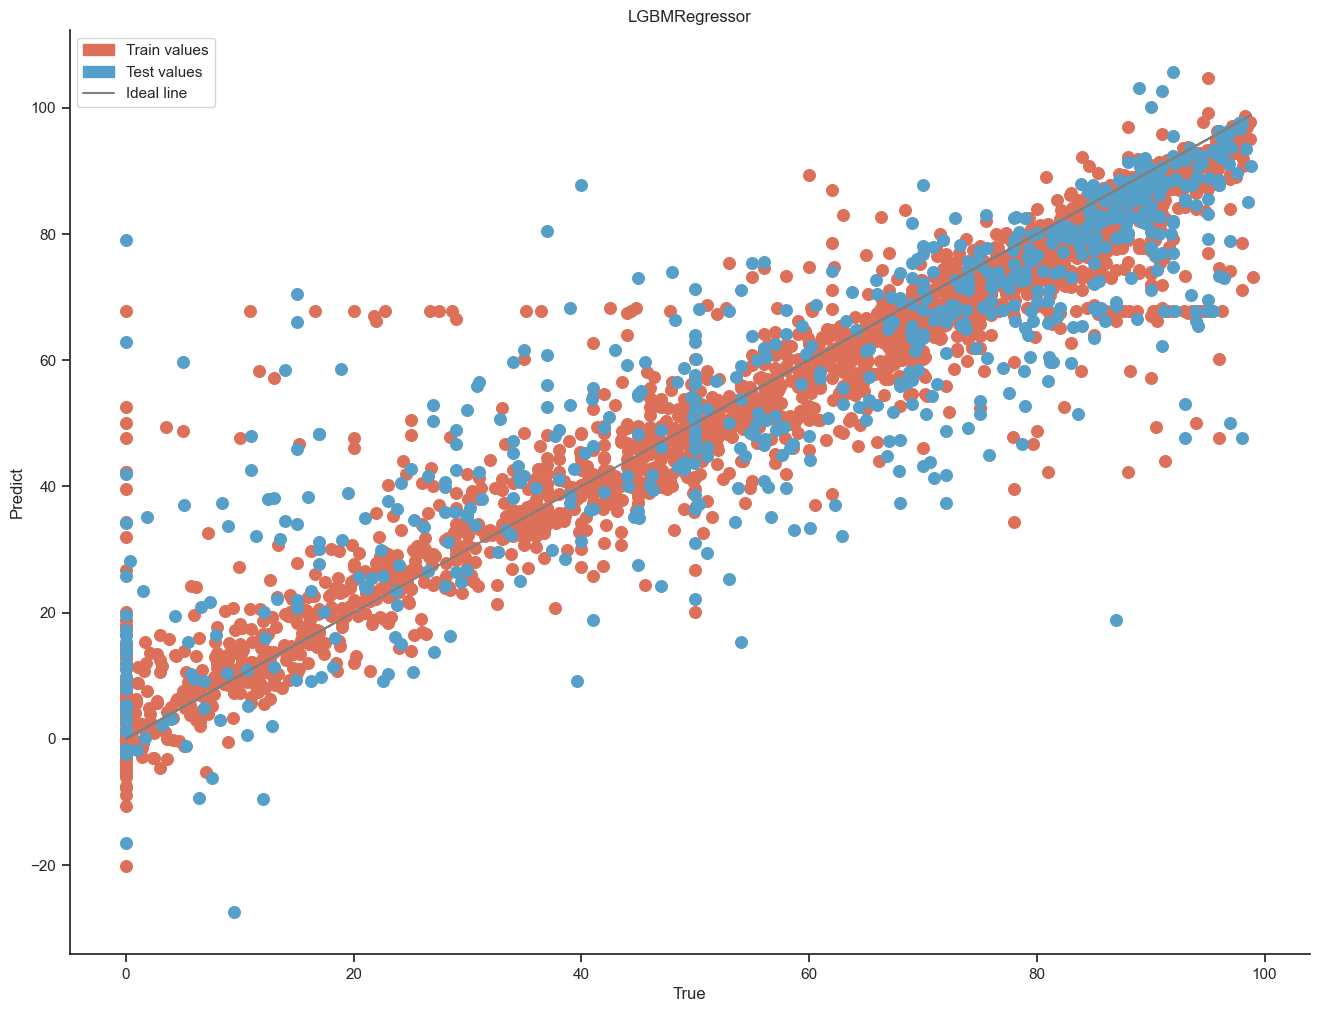

In [53]:
best_params = {'reg_alpha': 0.0024277041329914843, 'reg_lambda': 9.98216025280689, 'colsample_bytree': 0.3, 'subsample': 0.4,
                'learning_rate': 0.02, 'max_depth': 6, 'num_leaves': 459, 'min_child_samples': 15, 'min_data_per_groups': 79, 'max_bin': 97, 'min_child_weight': 0.002477919474264366,
                  'boosting_type': 'dart', 'scale_pos_weight': 8.842589967475636}



params=best_params
params['n_estimators'] = 20000
params['metric'] = 'rmse'
params['cat_smooth'] = params.pop('min_data_per_groups')
X = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\rdkit_right_desc.csv', index_col=0)[features]
y = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\target_right_desc.csv', index_col=0)['0']
y = pd.DataFrame(y)
cons = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['siRNA concentration'].apply(remove_trailing_period).astype(float)
X['Concentration_nM'] = cons[cons <= 100]
X['Experiment_used_to_check_activity'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Experiment used to check activity'].astype(float)
X['Target_gene'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Target gene'].astype(float)
#X['siRNA_concentration'] = pd.read_csv('E:\\My_projects\\ready_to_go_2.csv')['siRNA concentration'].astype(float)
X['Cell_or_Organism_used'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Cell or Organism used'].astype(float)
X['Transfection_method'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Transfection method'].astype(float)
X['Duration_after_transfection'] = pd.read_csv('E:\\My_projects\\unified_data\\unified_data\\info_right_desc.csv')['Duration after transfection'].astype(float)
X['target'] = y
X = X.drop_duplicates()
y = X['target']
X = X.drop(columns=['target'])
print('After hyperparams tuning')
X_train, X_valid, y_train, y_valid = data_prep(X, y)
print('Train:', len(X_train))
print('Valid:', len(X_valid), end='\n\n')

train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

data1 = lgb.Dataset(X, label=y)


print('Starting training...')

# train
gbm = lgb.train(params,
                train_data,
                num_boost_round=10000,
                valid_sets=[valid_data])
print()

# save model to file
print('Saving model...')
gbm.save_model('model.txt')

# predict
print('Starting predicting...')
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

# %%
from matplotlib.patches import Patch
y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
r2_test = metrics.r2_score(y_valid, y_pred)
MAE_test = metrics.mean_absolute_error(y_valid, y_pred)
MSE_test = metrics.mean_squared_error(y_valid, y_pred)
RMSE_test = np.sqrt(metrics.mean_squared_error(y_valid, y_pred))
r2_train = metrics.r2_score(y_train, y_train_pred)
MAE_train = metrics.mean_absolute_error(y_train, y_train_pred)
MSE_train = metrics.mean_squared_error(y_train, y_train_pred)
RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
n_test = len(y_valid)
p_test = X_valid.shape[1]
adj_r2_test = adjusted_r2_score(r2_test, n_test, p_test)

n_train = len(y_train)
p_train = X_train.shape[1]
adj_r2_train = adjusted_r2_score(r2_train, n_train, p_train)


print(X_train.shape)
real_patch = Patch(color='#DD7059', label='Train values')
pred_patch = Patch(color='#569FC9', label='Test values')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
f, ax = plt.subplots(figsize=(16, 12))
plt.scatter(y_train, y_train_pred, color='#DD7059', s=70)
plt.scatter(y_valid, y_pred, color='#569FC9',s=70)
plt.plot(y_valid, y_valid, color='gray')
plt.legend(handles=[real_patch, pred_patch, plt.Line2D([], [], color='gray', label='Ideal line')])
plt.title('LGBMRegressor')
plt.xlabel('True')
plt.ylabel('Predict')
plt.savefig('lgbm_tuned_nikita.png', dpi=1200)
print('r2_test:', r2_test)
print('MAE_test:', MAE_test)
print('MSE_test:', MSE_test)
print('RMSE_test:', RMSE_test)
print('Adjusted r2_test:', adj_r2_test)

print('r2_train:', r2_train)
print('MAE_train:', MAE_train)
print('MSE_train:', MSE_train)
print('RMSE_train:', RMSE_train)
print('Adjusted r2_train:', adj_r2_train)

In [54]:
print('r2_test:', r2_test)
print('MAE_test:', MAE_test)
print('MSE_test:', MSE_test)
print('RMSE_test:', RMSE_test)
print('Adjusted r2_test:', adj_r2_test)

print('r2_train:', r2_train)
print('MAE_train:', MAE_train)
print('MSE_train:', MSE_train)
print('RMSE_train:', RMSE_train)
print('Adjusted r2_train:', adj_r2_train)

r2_test: 0.749747581914725
MAE_test: 10.271335523773278
MSE_test: 213.65661863877494
RMSE_test: 14.616997593171279
Adjusted r2_test: 0.7107809424204781
r2_train: 0.9137412510467123
MAE_train: 5.2145616873705025
MSE_train: 70.8703549872957
RMSE_train: 8.418453241973593
Adjusted r2_train: 0.9107333907577562


In [55]:
X_train.shape

(2672, 90)